In [6]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
pl.style.use('apw-notebook')
%matplotlib inline
from scipy import stats

importgala.potential as gp
importgala.coordinates as gc
fromgala.units import galactic

In [7]:
G = galactic.get_constant('G') # kpc, solar masses, Myr
M = 1E12 # solar masses
r_s = 30. # kpc

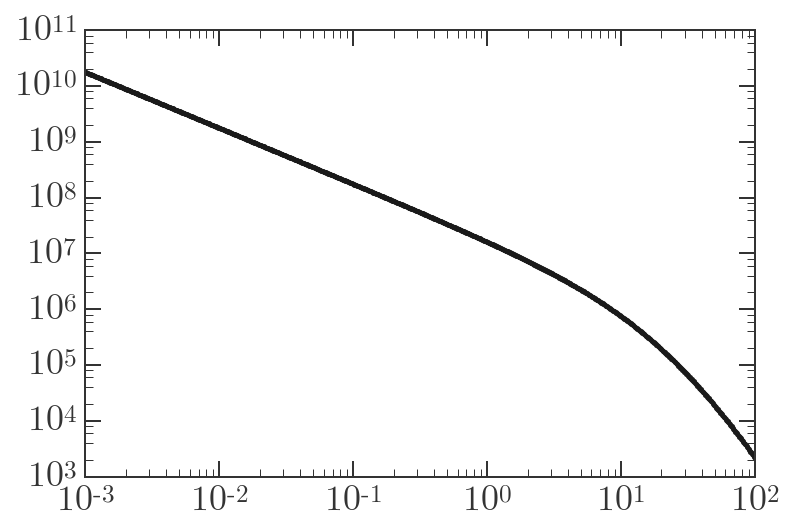

In [8]:
pot = gp.HernquistPotential(m=1E11, c=30., units=galactic)

q = np.zeros((3,1024))
q[0] = np.logspace(-3,2,q.shape[1])
pl.loglog(q[0], pot.density(q))

In [53]:
# msys = mass of the system?
def hernquist_ics(msys, rsys, r0, G=1., size=1, maxiter=None, seed=None):
    """
    The variable const represents the maximum value of 
    r**2 * v**2 * f(q), which occurs at r/r_0 = 0.63798179 and v/v_g = v_circ.
    
    Parameters
    ----------
    
    """
    np.random.seed(seed)
    
    # each particle mass
    masses = np.zeros(size) + msys*rsys**2 / (rsys+r0)**2 / size
    const = 1.20223157581242
    
    # maximum number of iterations
    maxiter = size*10
    
    # output arrays
    xyz = np.zeros((3,size))
    vxyz = np.zeros((3,size))
    
    nparticles = 0
    niter = 0
    while nparticles < size and niter < maxiter:
        xr = np.random.random() * rsys
        xv = np.random.random() * np.sqrt(2.*G*msys/r0)
        E = 0.5*xv*xv - G*msys/(xr+r0) # energy
        
        if E > 0 or E < -G*msys/r0:
            continue
        
        q = np.sqrt(-r0*E/(G*msys)) # ??
        p = np.random.random()
    
        numer = (3.*np.arcsin(q) + q*np.sqrt(1.-q*q)*(1.-2.*q*q)*(8.*q**4-8.*q**2-3.))
        denom = (1.-q**2)**2.5
        fq = numer/denom
        pn = (xr/r0)**2 * (xv**2/(G*msys/r0)) * fq/const
        
        if pn > 1.:
            raise ValueError("Unexpected pn value!")
        
        if p > pn: # Magic??
            continue
        
        cth = 2.*(np.random.random()-0.5)
        sth = np.sqrt(1.-cth**2)
        signs = 2.*(np.random.random()-.5)
        sth = signs*sth/np.abs(signs)
        phi = 2*np.pi*np.random.random()
        
        cthv = 2.*(np.random.random()-.5)
        sthv = np.sqrt(1.-cthv*cthv)
        signs = 2.*(np.random.random()-.5)
        sthv = signs*sthv/np.abs(signs)
        phiv = 2*np.pi*np.random.random()
        
        xyz[0,nparticles] = xr*sth*np.cos(phi)
        xyz[1,nparticles] = xr*sth*np.sin(phi)
        xyz[2,nparticles] = xr*cth
        
        vxyz[0,nparticles] = xv*sthv*np.cos(phiv)
        vxyz[1,nparticles] = xv*sthv*np.sin(phiv)
        vxyz[2,nparticles] = xv*cthv
        
        nparticles += 1
        niter += 1
    
    if niter == maxiter:
        raise ValueError("Ran for max. num of iterations ({})".format(maxiter))
    
    return masses, xyz, vxyz

In [74]:
m,xyz,vxyz = hernquist_ics(1E12, 100, 30., G=G, size=1000)

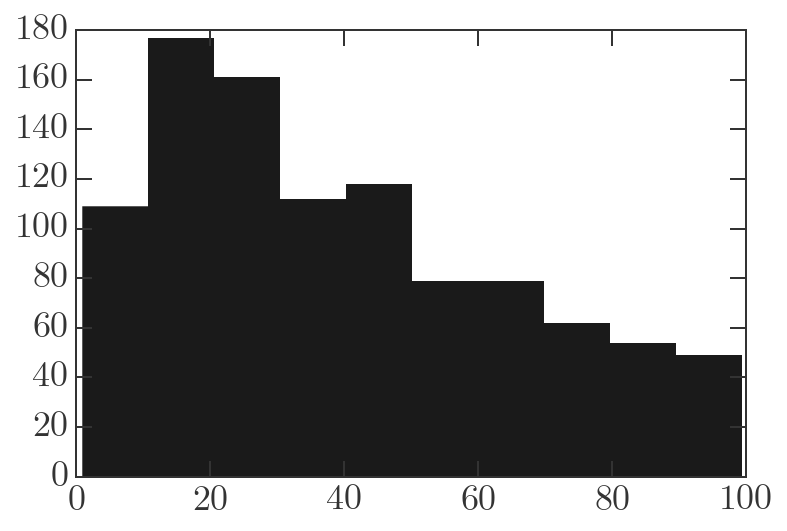

In [75]:
pl.hist(np.sqrt(np.sum(xyz**2,axis=0)));

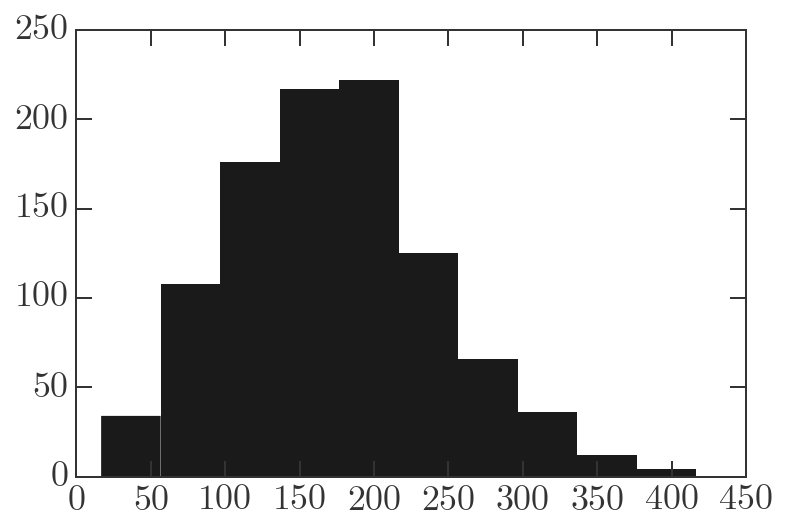

In [76]:
_v = (np.sqrt(np.sum(vxyz**2,axis=0))*u.kpc/u.Myr).to(u.km/u.s).value
pl.hist(_v);

### Take the random radii and velocity magnitudes and convert to isotropic full-space motion

(note: already done)

In [77]:
# phi_r = np.random.uniform(0, 2*np.pi, r.size)*u.radian
# theta_r = coord.Angle(np.arccos(2*np.random.uniform(size=r.size) - 1)*u.radian)
# pos = coord.PhysicsSphericalRepresentation(phi=phi_r, theta=theta_r, r=r*u.kpc)
# xyz = pos.represent_as(coord.CartesianRepresentation).xyz

In [78]:
# vxyz = np.zeros((3,N))
# vxyz[0] = v

# for i in range(N):
#     R = gc.Quaternion.random().rotation_matrix
#     vxyz[:,i] = R.dot(vxyz[:,i])
    
# vxyz = vxyz*u.km/u.s

### Convert to Galactocentric

In [79]:
c_gal = coord.Galactocentric(xyz*u.kpc).transform_to(coord.Galactic)
mu_l,mu_b,v_los = gc.vgal_to_hel(c_gal, vxyz*u.kpc/u.Myr)

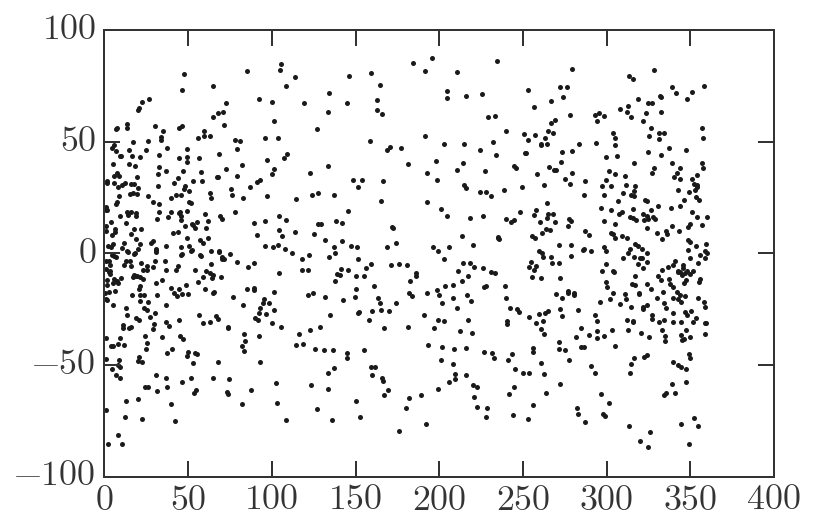

In [80]:
pl.plot(c_gal.l.degree, c_gal.b.degree, ls='none')

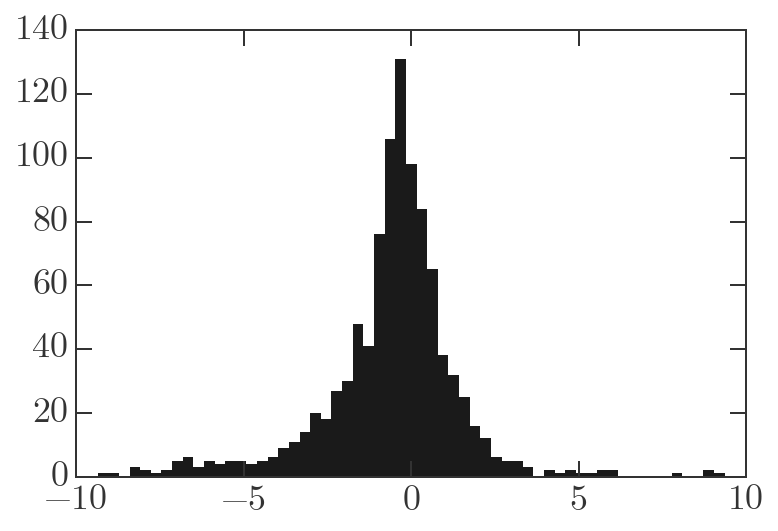

In [81]:
pl.hist(mu_l.value, bins=np.linspace(-10,10,64));

---

In [112]:
nobserved = 50
npropermotion = 20
frac_dist_err = 0.1 # 10%

In [113]:
_ix = np.arange(len(c_gal), dtype=int)
obs_ix = np.random.choice(_ix, size=nobserved, replace=False)

_ix = np.arange(nobserved, dtype=int)
no_pm_ix = np.random.choice(_ix, size=nobserved-npropermotion, replace=False)

In [114]:
data_l = c_gal[obs_ix].l.degree
data_b = c_gal[obs_ix].b.degree
true_data_d = c_gal[obs_ix].distance.to(u.kpc).value
err_d = frac_dist_err*true_data_d
data_d = np.random.normal(true_data_d, err_d)

In [115]:
true_data_mul = mu_l[obs_ix].to(u.mas/u.yr).value
true_data_mub = mu_b[obs_ix].to(u.mas/u.yr).value
true_data_vr = v_los[obs_ix].to(u.km/u.s).value

err_mul = np.zeros(nobserved) + 1.5 # mas/yr
err_mub = np.zeros(nobserved) + 1.5 # mas/yr
err_vr = np.zeros(nobserved) + 5. # km/s

# randomly delete some by making pm measurements have huge uncertainties
err_mul[no_pm_ix] = 1E5
err_mub[no_pm_ix] = 1E5

data_mul = np.random.normal(true_data_mul, err_mul)
data_mub = np.random.normal(true_data_mub, err_mub)
data_vr =np.random.normal(true_data_vr, err_vr)

--- 

First, what happens to velocity distribution if we just sub in uniform priors on proper motions

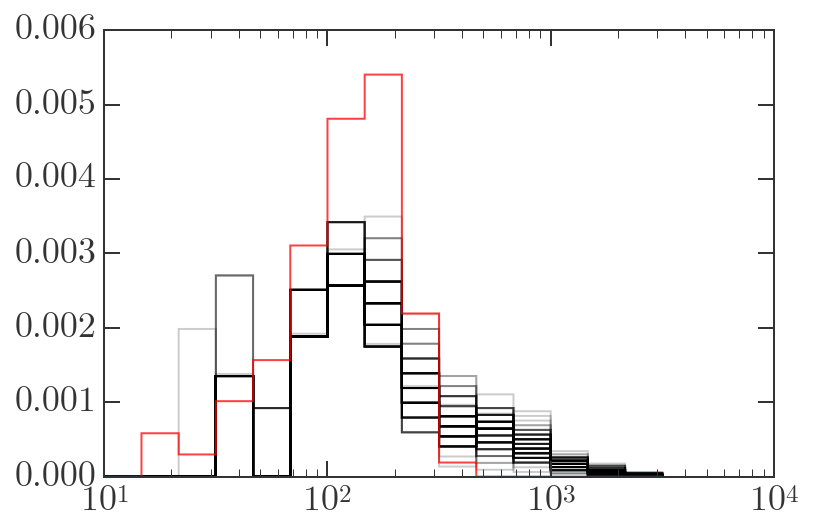

In [118]:
pm_prior_val = 5 # mas/yr

bins = np.logspace(1,3.5,16)
for i in range(100):
    this_c = coord.Galactic(l=data_l*u.degree, b=data_b*u.degree, distance=true_data_d*u.kpc)
    
    this_mul = true_data_mul.copy()
    this_mul[no_pm_ix] = np.random.uniform(-pm_prior_val,pm_prior_val,size=nobserved-npropermotion)
    this_mub = true_data_mub.copy()
    this_mub[no_pm_ix] = np.random.uniform(-pm_prior_val,pm_prior_val,size=nobserved-npropermotion)
    
    this_vxyz = gc.vhel_to_gal(this_c, pm=(this_mul*u.mas/u.yr,this_mub*u.mas/u.yr),
                               rv=true_data_vr*u.km/u.s)
    this_xyz = this_c.transform_to(coord.Galactocentric)
    
    pl.hist(np.sqrt(np.sum(this_vxyz**2,axis=0)), histtype='step', color='k', alpha=0.2, normed=True, bins=bins);

_v = (np.sqrt(np.sum(vxyz**2,axis=0))*u.kpc/u.Myr).to(u.km/u.s)
pl.hist(_v, histtype='step', color='r', alpha=0.75, normed=True, bins=bins);
pl.xscale('log')

---